## Training Word2Vec for Domain Specific Text

Using `gensim.model.Word2Vec` (skip-gram model) to get customized word embeddings given specific text.

In [1]:
import os
import gc
import re
import nltk
import string
import warnings
import editdistance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from gensim.test.utils import get_tmpfile, datapath
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def get_punctuation_list(exclude_puncts=None, include_puncts=None):
    """ Get a customized punctuation list """
    if not exclude_puncts:
        exclude_puncts = []
    if not include_puncts:
        include_puncts = []
    puncts = [p for p in string.punctuation if p not in exclude_puncts]
    puncts.extend([p for p in include_puncts])
    return list(set(puncts))

def separate_punctuation(x, puncts):
    """ Add spaces around punctuations """
    for s in puncts:
        x = x.replace(s, f' {s} ')
    return x

def strip_space(x):
    """ Remove extra space around words """
    return ' '.join([s.strip() for s in x.split()])

def clean_text(x):
    x = str(x).lower()
    x = x.replace('\n', '').replace('\t', '')
    x = separate_punctuation(x, puncts)
    x = strip_space(x)
    return x

class LossEvaluation(CallbackAny2Vec):
    """ Callback for logging training loss """
    def __init__(self):
        self.epoch = 0
        self.loss_prev_step = 0
    
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print(f'Epoch {str(self.epoch + 1):>2s} loss = {loss}')
        else:
            print(f'Epoch {str(self.epoch + 1):>2s} loss = {loss - self.loss_prev_step}')
        self.epoch += 1
        self.loss_prev_step = loss

In [3]:
data_path = '../input/quora-question-pairs'
train = pd.read_csv(os.path.join(data_path, 'train.csv.zip'))
test = pd.read_csv(os.path.join(data_path, 'test.csv.zip'))
embedding_size = 100

print(f'Training data size = {train.shape}')
print(f'Test data size = {test.shape}')

Training data size = (404290, 6)
Test data size = (3563475, 3)


In [4]:
train[['question1', 'question2']].fillna('', inplace=True)
test[['question1', 'question2']].fillna('', inplace=True)

puncts = get_punctuation_list(exclude_puncts=['$', '-', '_'])
question_text = train['question1'].tolist() + train['question2'].tolist() +\
                test['question1'].tolist() + test['question2'].tolist()
del train, test
gc.collect()

question_text_processed_split = [clean_text(q).split() for q in question_text]

print(f'Number of questions = {len(question_text_processed_split)}')

Number of questions = 7935530


In [5]:
%%time
path = get_tmpfile('word2vec.model')
training_params = dict(size=embedding_size,
                       window=5,
                       min_count=5,
                       iter=20,
                       sg=1,
                       workers=4,
                       compute_loss=True,
                       callbacks=[LossEvaluation()])
model = Word2Vec(question_text_processed_split, **training_params)
model.save('word2vec.model')

Epoch  1 loss = 68664608.0
Epoch  2 loss = 6270016.0
Epoch  3 loss = 6513784.0
Epoch  4 loss = 6586728.0
Epoch  5 loss = 6545976.0
Epoch  6 loss = 6518232.0
Epoch  7 loss = 6475904.0
Epoch  8 loss = 6428136.0
Epoch  9 loss = 6361736.0
Epoch 10 loss = 6295912.0
Epoch 11 loss = 6263880.0
Epoch 12 loss = 1292816.0
Epoch 13 loss = 0.0
Epoch 14 loss = 0.0
Epoch 15 loss = 0.0
Epoch 16 loss = 0.0
Epoch 17 loss = 0.0
Epoch 18 loss = 0.0
Epoch 19 loss = 0.0
Epoch 20 loss = 0.0
CPU times: user 3h 52min 43s, sys: 36.8 s, total: 3h 53min 19s
Wall time: 1h 4min 47s


In [6]:
vocab = sorted(list(model.wv.vocab.keys()))
model.wv.save_word2vec_format(f'quora_questions_w2v_{embedding_size}d.txt')
print(f'Number of vocabulary {len(vocab)}')

Number of vocabulary 105427


In [7]:
word_vectors = model.wv
accuracy_evaluation = word_vectors.accuracy(
    '../input/questionswords/questions-words.txt',
    case_insensitive=False)

for idx, result in enumerate(accuracy_evaluation):
    section = result['section']
    correct_num = len(result['correct'])
    incorrect_num = len(result['incorrect'])
    print(f'section {idx}: {section:27s} correct/incorrect = {correct_num}/{incorrect_num}')

section 0: capital-common-countries    correct/incorrect = 0/0
section 1: capital-world               correct/incorrect = 0/0
section 2: currency                    correct/incorrect = 0/0
section 3: city-in-state               correct/incorrect = 0/0
section 4: family                      correct/incorrect = 156/150
section 5: gram1-adjective-to-adverb   correct/incorrect = 13/587
section 6: gram2-opposite              correct/incorrect = 25/355
section 7: gram3-comparative           correct/incorrect = 336/996
section 8: gram4-superlative           correct/incorrect = 265/665
section 9: gram5-present-participle    correct/incorrect = 249/681
section 10: gram6-nationality-adjective correct/incorrect = 0/0
section 11: gram7-past-tense            correct/incorrect = 108/1082
section 12: gram8-plural                correct/incorrect = 329/861
section 13: gram9-plural-verbs          correct/incorrect = 109/443
section 14: total                       correct/incorrect = 1590/5820


In [8]:
# A -> B is like C -> D
accuracy_evaluation[4]['correct'][:5]

family_words = []
for pairs in accuracy_evaluation[4]['correct']:
    family_words.extend(list(pairs))

family_words = list(set(family_words))
print(f'Number of family words = {len(family_words)}')
family_words_embeddings = np.zeros((len(family_words), embedding_size))
for idx, word in enumerate(family_words):
    family_words_embeddings[idx, :] = word_vectors[word]
print(f'Shape of family words embedding matrix = {family_words_embeddings.shape}')

Number of family words = 36
Shape of family words embedding matrix = (36, 100)


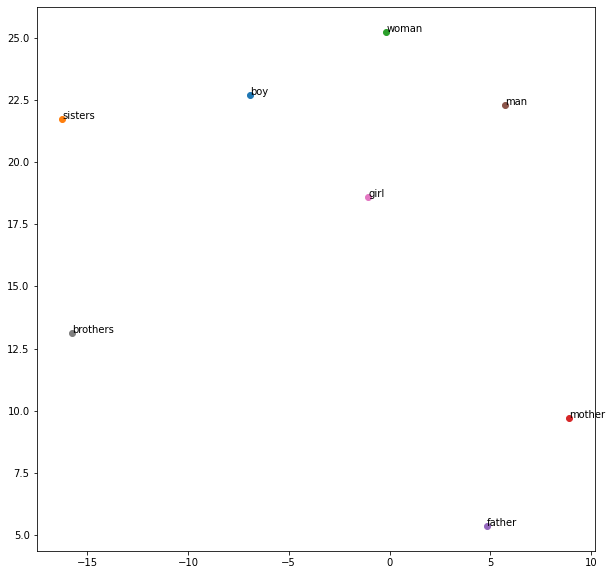

In [9]:
tsne = TSNE(n_components=2, perplexity=30, init="pca", n_iter=5000, method="exact")
low_dim_embeddings = tsne.fit_transform(family_words_embeddings)

plt.figure(figsize=(10, 10))  
for idx, word in enumerate(family_words):
    if word not in ['boy', 'girl',
                    'brothers', 'sisters',
                    'father', 'mother',
                    'woman', 'man']:
        continue
    x, y = low_dim_embeddings[idx, :]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y))
plt.show()

In [10]:
# A -> B is like C -> D
accuracy_evaluation[11]['correct'][:5]

past_tense_words = []
for pairs in accuracy_evaluation[11]['correct']:
    past_tense_words.extend(list(pairs))

past_tense_words = list(set(past_tense_words))
print(f'Number of past-tense words = {len(past_tense_words)}')
past_tense_words_embeddings = np.zeros((len(past_tense_words), embedding_size))
for idx, word in enumerate(past_tense_words):
    past_tense_words_embeddings[idx, :] = word_vectors[word]
print(f'Shape of past-tense words embedding matrix = {past_tense_words_embeddings.shape}')

Number of past-tense words = 60
Shape of past-tense words embedding matrix = (60, 100)


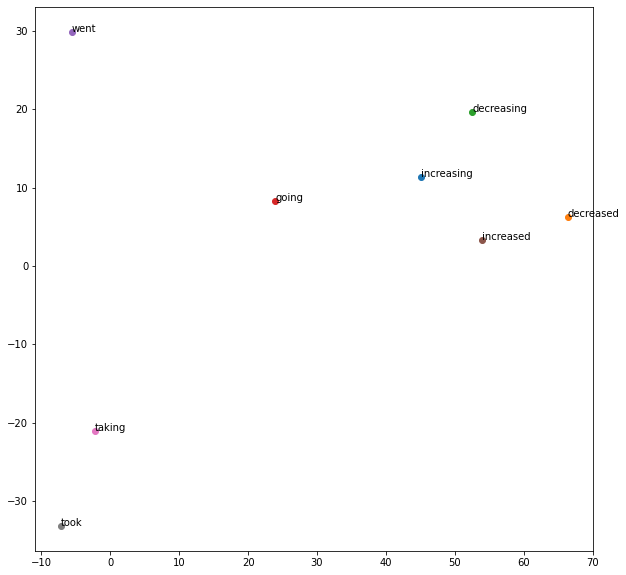

In [11]:
tsne = TSNE(n_components=2, perplexity=30, init="pca", n_iter=5000, method="exact")
low_dim_embeddings = tsne.fit_transform(past_tense_words_embeddings)

plt.figure(figsize=(10, 10))  
for idx, word in enumerate(past_tense_words):
    if word not in ['decreasing', 'decreased',
                    'increasing', 'increased',
                    'taking', 'took',
                    'going', 'went']:
        continue
    x, y = low_dim_embeddings[idx, :]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y))
plt.show()